<a href="https://colab.research.google.com/github/FMagnani/Generalized-Lotka-Volterra_N-species-model/blob/master/mnist_coil20/mnist_umap_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST dataset embedded with UMAP

## Import data

The MNIST dataset can be obtained here: http://yann.lecun.com/exdb/mnist/  

The important variables defined here are: 
- data, np.array of shape (n_samples, n_features)
- labels, np.array of shape (n_samples)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

!pip install idx2numpy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import idx2numpy 
import matplotlib.image as img


train_path = "drive/MyDrive/Benchmark_Datasets/mnist/train-images.idx3-ubyte"
label_path = "drive/MyDrive/Benchmark_Datasets/mnist/train-labels.idx1-ubyte"
         
data_matrix = idx2numpy.convert_from_file(train_path) # shape = (60000, 28, 28)
        
n_samples, dim1, dim2 = data_matrix.shape
vector_dim = dim1*dim2

data = data_matrix.reshape(n_samples, vector_dim) # shape = (60000, 784)
labels = idx2numpy.convert_from_file(label_path)  
        
dataframe = pd.DataFrame(data) # Pandas dataframe, in case it's needed
dataframe["labels"] = labels

# In case it's needed to show the image corresponding to a sample:
def show_sample(sample_number):

        plt.imshow(data_matrix[sample_number], cmap="gray")


# total data 60'000
n_subsample = 60000
data = data[:n_subsample, :]
labels = labels[:n_subsample]


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Embedding

It's basically the first half of the UMAP algorithm. The second section of UMAP is to optimize this embedding, minimizing the Cross Entropy cost function. 
Here the following steps will be done:
- Distance matrix computation
- Fuzzy topological graph computation
- Laplacian embedding of the fuzzy topological graph
- Optimization of the layout with UMAP

### Example

In order to give the idea of the stuff we're computing, here some plots for a *n_neighbors* parameter equal to 15.

In [ ]:
!pip install umap-learn
import umap
import scipy.sparse as sparse
from umap.spectral import spectral_layout

n_neighbors = 15

fuztop_graph, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(
                                                         data,
                                                         n_neighbors = n_neighbors,
                                                         random_state = 123456,
                                                         metric = 'euclidean',
                                                         metric_kwds={},
                                                         knn_indices=None,
                                                         knn_dists=None,
                                                         angular=False,
                                                         set_op_mix_ratio=1.0,
                                                         local_connectivity=1.0,
                                                         apply_set_operations=True,
                                                         verbose=False,
                                                         return_dists=True,
                                                        )

dists = sparse.find(dists)[2]
weights = sparse.find(fuztop_graph)[2]

annotation = "Distances mean:"+str(np.mean(dists))[:4]+", std:"+str(np.std(dists))[:4] +\
             "\nSigma mean:"+str(np.mean(sigmas))[:4]+", std:"+str(np.std(sigmas))[:4] +\
             "\nWeigths mean:"+str(np.mean(weights))[:4]+", std:"+str(np.std(weights))[:4]



fuztop_embedding = spectral_layout(data, fuztop_graph, dim=2,
                                   random_state=123456, metric='euclidean', metric_kwds={})

umap_embedding = umap.UMAP(n_neighbors=n_neighbors, n_components=2, metric='euclidean').fit_transform(data)


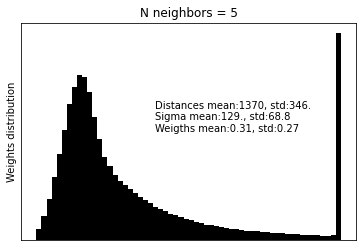

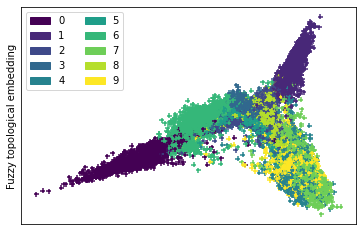

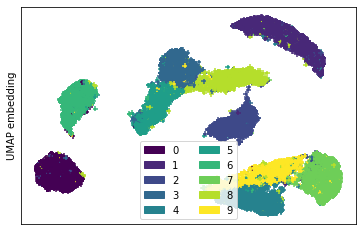

In [ ]:
import matplotlib.patches as mpatches # For custom legend
from matplotlib.colors import Normalize # For custom legend

fig1, ax1 = plt.subplots(1, 1)
fig2, ax2 = plt.subplots(1, 1)
fig3, ax3 = plt.subplots(1, 1)

ax = [ax1, ax2, ax3]

ax[0].hist(weights, bins=60, color='black')
ax[1].scatter(fuztop_embedding[:,0], fuztop_embedding[:,1],
              c = labels, cmap='viridis', marker='+', s=25)
ax[2].scatter(umap_embedding[:,0], umap_embedding[:,1],
              c = labels, cmap='viridis', marker='+', s=25)

for i in range(3)[1:]:
  ax[i].get_xaxis().set_ticks([])
  ax[i].get_yaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[0].get_xaxis().set_ticks([])

# Legend
cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=9)
legend_list = []
for c in range(10):
  color = cmap(norm(c))
  patch = mpatches.Patch(color=color, label=str(c))
  legend_list.append(patch)
ax[1].legend(handles=legend_list, ncol=2)
ax[2].legend(handles=legend_list, loc='lower center', ncol=2)

ax[0].set_ylabel("Weights distribution")
ax[0].annotate(annotation, (0.4,0.5), xycoords='axes fraction')
ax[1].set_ylabel("Fuzzy topological embedding")
ax[2].set_ylabel("UMAP embedding")
ax[0].set_title("N neighbors = 5")

plt.show()


Wonderful result, now the computation for various *n_neighbors* values.

### Various n_neighbors

I will create the data with Colab, and plot them with my pc.

In [ ]:
!pip install umap-learn
!pip install pandas
import umap
import scipy.sparse as sparse
from umap.spectral import spectral_layout
import pandas as pd

neighbors_list = [5, 80, 300]

embedding_df = pd.DataFrame()
embedding_df["Labels"] = labels

weights_df = []
dists_df = []
sigmas_df = pd.DataFrame()

for n_neighbors in neighbors_list:

  fuztop_graph, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(
                                                         data,
                                                         n_neighbors = n_neighbors,
                                                         random_state = 123456,
                                                         metric = 'euclidean',
                                                         metric_kwds={},
                                                         knn_indices=None,
                                                         knn_dists=None,
                                                         angular=False,
                                                         set_op_mix_ratio=1.0,
                                                         local_connectivity=1.0,
                                                         apply_set_operations=True,
                                                         verbose=False,
                                                         return_dists=True,
                                                        )

  dists = sparse.find(dists)[2]
  weights = sparse.find(fuztop_graph)[2]

  weights_df.append( pd.DataFrame({'Weights_'+str(n_neighbors): weights}) )
  dists_df.append( pd.DataFrame({"Distances_"+str(n_neighbors): dists}) )

  sigmas_df[ "Sigmas_"+str(n_neighbors) ] = sigmas

  fuztop_embedding = spectral_layout(data, fuztop_graph, dim=2,
                                     random_state=123456, metric='euclidean', metric_kwds={})

  umap_embedding = umap.UMAP(n_neighbors=n_neighbors, n_components=2, metric='euclidean').fit_transform(data)


  embedding_df[ "FuzTop_x_"+str(n_neighbors) ] = fuztop_embedding[:,0]
  embedding_df[ "FuzTop_y_"+str(n_neighbors) ] = fuztop_embedding[:,1]
  embedding_df[ "Umap_x_"+str(n_neighbors) ] = umap_embedding[:,0]
  embedding_df[ "Umap_y_"+str(n_neighbors) ] = umap_embedding[:,1]


weights_df = pd.concat([weights_df[0], weights_df[1], weights_df[2]], axis=1) 
dists_df = pd.concat([dists_df[0], dists_df[1], dists_df[2]], axis=1) 


Save data to csv, ready for the download.

In [ ]:

embedding_df.to_csv("mnist_embeddings.csv")
weights_df.to_csv("mnist_weights.csv")
dists_df.to_csv("mnist_distances.csv")
sigmas_df.to_csv("mnist_sigmas.csv")
